JSRT Dataset (247 images)

This code prepares the dataset for left and right lung segmentation. Two channel masks contain ground truth left lung and right lung.<br>
(Clavicles and heart could also be included as additional channels)

Segmentation masks are read from .gif files while the X-ray images are from .IMG files. 


Folders needed in the current directory: images (train/test) of .IMG format, label1 (train/test) of .gif format, and label2 (train/test) of .gif format.

Train and test folders are already separated: 124 for training and 123 for testing. 

The train set is further split: 111 for training and 13 as the validation set for model selection.

In [15]:
#Mount your google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#Change directory to the (current) JSRT directory
%cd 'path_to_the_JSRT_dir'
#Verify the current directory
!pwd

/content/drive/My Drive/UCLA_PC_June17_2020/miccai_2020/pass/datasets/jsrt
/content/drive/My Drive/UCLA_PC_June17_2020/miccai_2020/pass/datasets/jsrt


In [10]:
import scipy.io as sio
import numpy as np
import glob, re
import matplotlib.pyplot as plt
from skimage.transform import resize


#train-set
#Get the image and label (left and right lungs) files
imgfiles = glob.glob("./images/train" + "/*.IMG")
lab1files = glob.glob("./label1/train" + "/*.gif")
lab2files = glob.glob("./label2/train" + "/*.gif")

#Sort the files in ascending order
imgfiles.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[0-9]|[0-9]+', var)])
lab1files.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[0-9]|[0-9]+', var)])
lab2files.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[0-9]|[0-9]+', var)])

train_images, train_labels = [], [] #initialize train_images and train_labels to store the images and labels 

img_shape = (2048, 2048) # matrix size: current image size
dtype = np.dtype('>u2') # big-endian unsigned integer (16bit)

for i in range(len(imgfiles)):
    #print(imgfiles[i], lab1files[i], lab2files[i])
    
    fid = open(imgfiles[i], 'rb')
    data = np.fromfile(fid, dtype)
    im = data.reshape(img_shape)
    im = 1. - im/np.max(im)
    im = resize(im, [256, 256, 1]) #new size: 256x256

    lab1 = plt.imread(lab1files[i])
    lab2 = plt.imread(lab2files[i])
    lab1 = resize(lab1, [256, 256, 1]) #left lung
    lab2 = resize(lab2, [256, 256, 1]) #right lung
    lab = np.concatenate([lab1, lab2], -1)
    
    train_images.append(im)
    train_labels.append(lab)

train_images = np.reshape(train_images, [-1, 256, 256, 1])
train_labels = np.reshape(train_labels, [-1, 256, 256, 2])

idx = np.arange(train_images.shape[0])
idx = np.random.shuffle(idx)
train_images = train_images[idx][0]
train_labels = train_labels[idx][0]

train_images.shape, train_labels.shape

((124, 256, 256, 1), (124, 256, 256, 2))

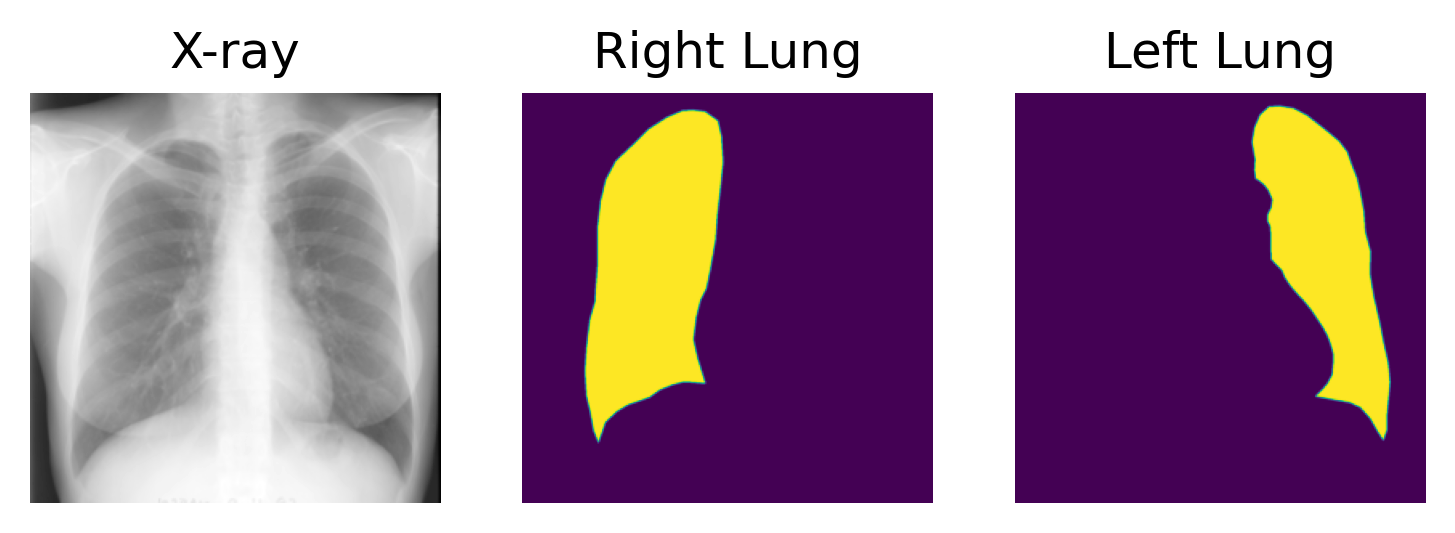

In [11]:
#Visualize an image and corresponding labels (left/right lungs)
plt.figure(dpi=300)
plt.subplot(131)
plt.imshow(train_images[0,:,:,0], cmap='gray')
plt.title('X-ray')
plt.axis('off')
plt.subplot(132)
plt.imshow(train_labels[0,:,:,0])
plt.title('Right Lung')
plt.axis('off')
plt.subplot(133)
plt.imshow(train_labels[0,:,:,1])
plt.title('Left Lung')
plt.axis('off')
plt.show()

In [12]:
#test-set

imgfiles = glob.glob("./images/test" + "/*.IMG")
lab1files = glob.glob("./label1/test" + "/*.gif")
lab2files = glob.glob("./label2/test" + "/*.gif")

x_test = []
y_test = []

img_shape = (2048, 2048) # matrix size
dtype = np.dtype('>u2') # big-endian unsigned integer (16bit)


for i in range(len(imgfiles)):
    fid = open(imgfiles[i], 'rb')
    data = np.fromfile(fid, dtype)
    im = data.reshape(img_shape)
    im = 1. - im/np.max(im)
    im = resize(im, [256, 256, 1])
    
    
    lab1 = plt.imread(lab1files[i])
    lab2 = plt.imread(lab2files[i])
    lab1 = resize(lab1, [256, 256, 1])
    lab2 = resize(lab2, [256, 256, 1])
    lab = np.concatenate([lab1, lab2], -1)
    
    x_test.append(im)
    y_test.append(lab)

x_test = np.reshape(x_test, [-1, 256, 256, 1])
y_test = np.reshape(y_test, [-1, 256, 256, 2])
x_test.shape, y_test.shape

((123, 256, 256, 1), (123, 256, 256, 2))

In [13]:
from sklearn.model_selection import train_test_split

#Split the train_images into into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1)

#Check the shapes/sizes of train, test, and validation sets
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((111, 256, 256, 1),
 (111, 256, 256, 2),
 (123, 256, 256, 1),
 (123, 256, 256, 2),
 (13, 256, 256, 1),
 (13, 256, 256, 2))

In [14]:
#Save as mat file in a dictionary
sio.savemat('jsrt.mat', {'x_train':x_train, 'y_train':y_train, 'x_val':x_val, 'y_val':y_val, 'x_test':x_test, 'y_test':y_test})